# Loggi Last-Mile Forecasting

## Business Problem

Loggi’s mission is to connect Brazil, delivering anything to anyone as quickly as possible. Through
technology (mobile, AI, automation, IoT), Loggi has created a next-generation logistics network and is, in
an unprecedented way, positioned to unleash the growth of a new trade-in Brazil with a fast, costeffective
and reliable logistics solution.

Loggi’s current network is composed of tens of thousands of partner drivers connecting customers to
hundreds of small hubs distributed all across Brazil, responsible for local operations. We also have a
couple of large cross-docking facilities connecting the small hubs through a large scale network of
ground and air transportation, responsible for national operations. With this model, we want to be
present in all Brazilian cities by the end of 2020.

New requirements for e-commerce customers that have emerged in recent years have brought greater
complexity to the logistics process, making last-mile delivery activity one of the most expensive and
least efficient steps in the parcel delivery supply chain.

At Loggi, the last-mile activity includes distribution centers, named as agencies, in the main cities of the
Brazilian territory. Depending on the delivery volume, a city can have several agencies. The last-mile
delivery itself is carried out through autonomous drivers (independent contractors), a fact that implies
some specific challenges for efficiently allocating drivers to delivery routes.

Currently, Loggi’s agencies know the demand of last-mile deliveries for a given day, but have a reduced
visibility on the supply (flow) of drivers during the hours of that day - what impacts its capacity to
allocate drivers to itineraries. Besides, it is known that driver habits related to hour of the day (time
slot), days leading up to and following holidays, rainy days, strong traffic days, etc. could affect the
driver's motivation to accept a new itinerary. Analyzing these data could make it feasible to understand
how much demand an agency is able to meet in a specific day hour and during the day. The visibility of
the hourly capacity would allow agencies to best distribute and schedule the process for allocating
drivers during the hours of the day.

## DS Challenge

The DS challenge is creating a computational tool to analyze the current flow of Loggi's registered
drivers during a given day, for a specific agency, and predict the capacity of this agency to allocate
drivers to itineraries for that day, in an hourly base. This tool is intended to support immediate operational actions, as well as aligning expectations about short-term allocation potential.

## Environment setup

In [1]:
#importing necessery libraries for future analysis of the dataset
import pandas as pd
import datetime as dt
import numpy as np
import os
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import pyodbc

## SQL Connection setup

In [2]:
def run_query(sql):
    cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                          "Server=DESKTOP-9H6BQ2G\SQL2019;"
                          "Database=Loggi;"
                          "Trusted_Connection=yes;")

    return pd.read_sql_query(sql, cnxn)

## Import Data and Start Analisys

In [52]:
sql = """
select 
    DATENAME(DW, ava.sent_f) as 'Weekday',
    CAST(ava.sent_f as DATE) as 'Dia',
    DATEPART(HOUR, ava.sent_f) as 'Hora',
    DATEPART(MINUTE,DATEADD(MINUTE, (DATEDIFF(MINUTE, '1990-01-01T00:00:00', ava.sent_f) / 30) * 30, '1990-01-01T00:00:00')) as 'Periodo',
    COUNT(DISTINCT ava.driver_id) as 'Avail'
from availabilitydist ava
join driver drv
    on drv.driver_id = ava.driver_id
    and drv.operational_status = 'habilitado'
where ava.sent_f between '20200201' and '20200205' 
and GEOGRAPHY::Point(-23.4678447, -46.5122355, 4326).STDistance(GEOGRAPHY::Point([lat], [lng], 4326)) < 6000
group by 
    DATENAME(DW, ava.sent_f),
    CAST(ava.sent_f as DATE),
    DATEPART(HOUR, ava.sent_f),
    DATEDIFF(MINUTE, '1990-01-01T00:00:00', sent_f) / 30
order by Dia, Hora, Periodo
"""
df_avail = run_query(sql)

In [22]:
sql = """
select
    (select count(distinct driver_id) from rejected where sent_f between '20191201' and '20200228') as 'Reject',
    (select count(distinct driver_id) from unmatched where sent_f between '20191201' and '20200228') as 'Unmatch', 
    (select count(distinct driver_id) from availabilitydist where sent_f between '20191201' and '20200228') as 'Avail'
"""
df_reject = run_query(sql)


In [48]:
sql = """
    select 
        CAST(created_time as DATE) as 'Dia',
        DATEPART(HOUR, created_time) as 'Hora',
        COUNT(*) as 'Demand'
    from itinerarydist
    where created_time between '20200201' and '20200205'
    group by CAST(created_time as DATE), DATEPART(hour, created_time)
    order by CAST(created_time as DATE), DATEPART(hour, created_time)
"""
df_iti = run_query(sql)
df_iti['Weekday'] = df_iti['Dia'].apply(lambda x: dt.datetime.strftime(x, '%A'))

In [61]:
sql = """
    select
        cast(dia as date) as 'Dia',
        precipitacion as 'Prec'
    from weather
    where dia between '20200201' and '20200205'
"""
df_prec = run_query(sql)
df_prec['Weekday'] = df_prec['Dia'].apply(lambda x: dt.datetime.strftime(x, '%A'))

,Dia,Prec,Weekday


## Merge information to better analysis

In [50]:
df_reject['Perc'] = (df_reject['Reject'] + df_reject['Unmatch']) / df_reject['Avail']
perc_reject = df_reject['Perc'][0]
perc_reject

0.5363060989643268

In [59]:
from functools import reduce

data_frames = [df_iti, df_avail]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Dia','Hora','Weekday'],
                                            how='inner'), data_frames)

df_merged['Reject'] = round(df_merged['Avail'] * perc_reject,0)
df_merged

,Dia,Hora,Demand,Weekday,Periodo,Avail,Reject
0,2020-02-01,9,26,Saturday,0,164,88.0
1,2020-02-01,9,26,Saturday,30,172,92.0
2,2020-02-01,10,65,Saturday,0,190,102.0
3,2020-02-01,10,65,Saturday,30,170,91.0
4,2020-02-01,11,54,Saturday,0,163,87.0
5,2020-02-01,11,54,Saturday,30,177,95.0
6,2020-02-01,12,17,Saturday,0,174,93.0
7,2020-02-01,12,17,Saturday,30,176,94.0
8,2020-02-01,13,14,Saturday,0,173,93.0
9,2020-02-01,13,14,Saturday,30,190,102.0


In [63]:
#df_merged_w = pd.merge(df_merged, df_prec,on=['Dia','Weekday'], how='inner')
df_merged_w = df_merged
#df_merged_w['Prec'] = pd.to_numeric(df_merged_w['Prec'])

df_merged_w['Offer'] = df_merged_w['Avail'] - df_merged_w['Reject']
df_merged_w['Weekday'] = df_merged_w['Weekday'].astype(pd.api.types
                        .CategoricalDtype(categories=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))

df_merged_w['Weekend'] = df_merged_w['Weekday'].apply(lambda x: 1 if (x == 'Sunday' or x == 'Saturday') else 0)
df_merged_w.head(50)

,Dia,Hora,Demand,Weekday,Periodo,Avail,Reject,Offer,Weekend
0,2020-02-01,9,26,Saturday,0,164,88.0,76.0,1
1,2020-02-01,9,26,Saturday,30,172,92.0,80.0,1
2,2020-02-01,10,65,Saturday,0,190,102.0,88.0,1
3,2020-02-01,10,65,Saturday,30,170,91.0,79.0,1
4,2020-02-01,11,54,Saturday,0,163,87.0,76.0,1
5,2020-02-01,11,54,Saturday,30,177,95.0,82.0,1
6,2020-02-01,12,17,Saturday,0,174,93.0,81.0,1
7,2020-02-01,12,17,Saturday,30,176,94.0,82.0,1
8,2020-02-01,13,14,Saturday,0,173,93.0,80.0,1
9,2020-02-01,13,14,Saturday,30,190,102.0,88.0,1


In [64]:
df_merged_dummy = df_merged_w

list_cat_col = df_merged_w.select_dtypes(include=['category']).columns 

for i in list_cat_col:
    df_merged_dummy=pd.concat([df_merged_dummy,pd.get_dummies(df_merged_dummy[i],prefix=i)],axis=1).drop([i],axis=1)

df_merged_dummy.head()

,Dia,Hora,Demand,Periodo,Avail,Reject,Offer,Weekend,Weekday_Monday,Weekday_Tuesday,Weekday_Wednesday,Weekday_Thursday,Weekday_Friday,Weekday_Saturday,Weekday_Sunday
0,2020-02-01,9,26,0,164,88.0,76.0,1,0,0,0,0,0,1,0
1,2020-02-01,9,26,30,172,92.0,80.0,1,0,0,0,0,0,1,0
2,2020-02-01,10,65,0,190,102.0,88.0,1,0,0,0,0,0,1,0
3,2020-02-01,10,65,30,170,91.0,79.0,1,0,0,0,0,0,1,0
4,2020-02-01,11,54,0,163,87.0,76.0,1,0,0,0,0,0,1,0


## Exploring and Visualizing Data

Text(0.5, 1.0, 'Itinerary Demand by Hours')

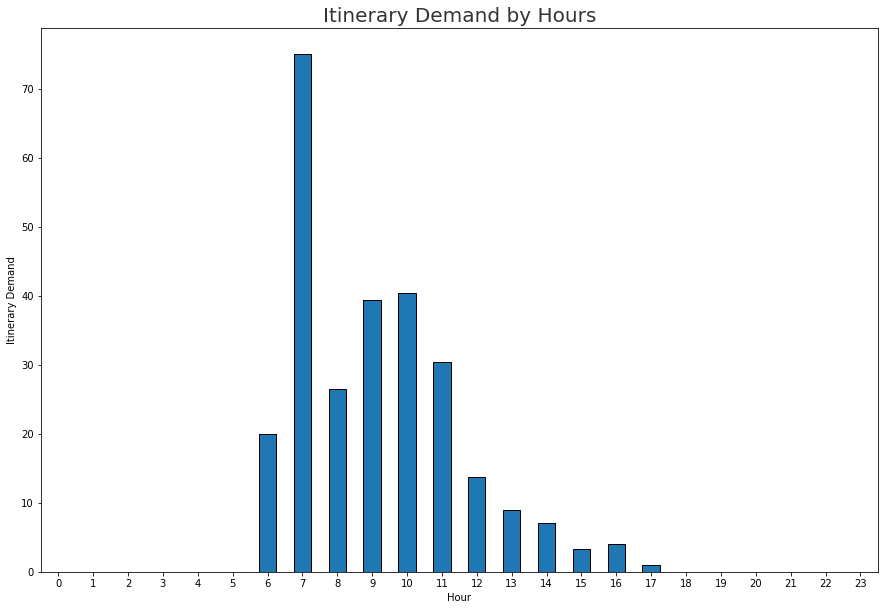

In [65]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Hora')['Demand'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Itinerary Demand')
plt.xlabel('Hour')
plt.title('Itinerary Demand by Hours', alpha=0.8, fontsize=20)

Text(0.5, 1.0, 'Drivers Availability by Hours')

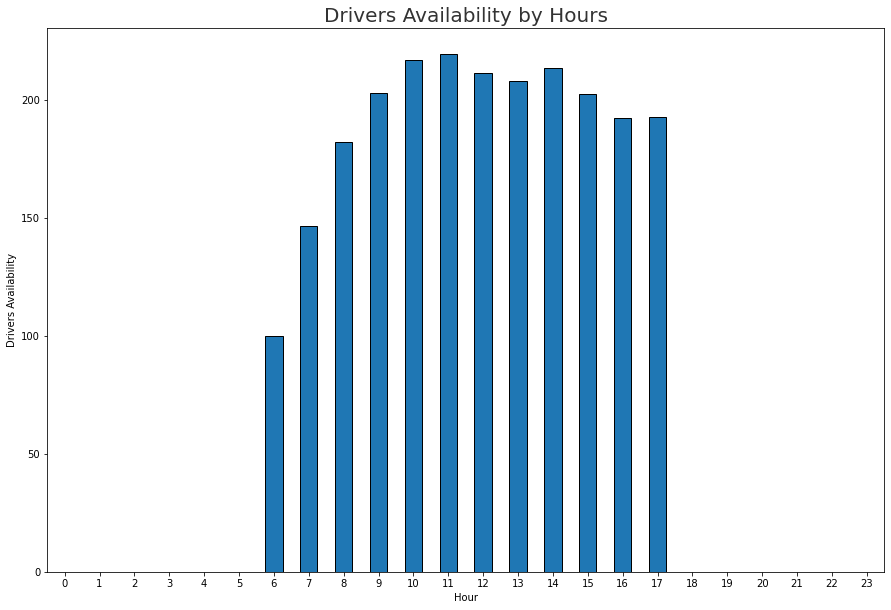

In [66]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Hora')['Avail'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Drivers Availability')
plt.xlabel('Hour')
plt.title('Drivers Availability by Hours', alpha=0.8, fontsize=20)

Text(0.5, 1.0, 'Itineraries Rejected by Hours')

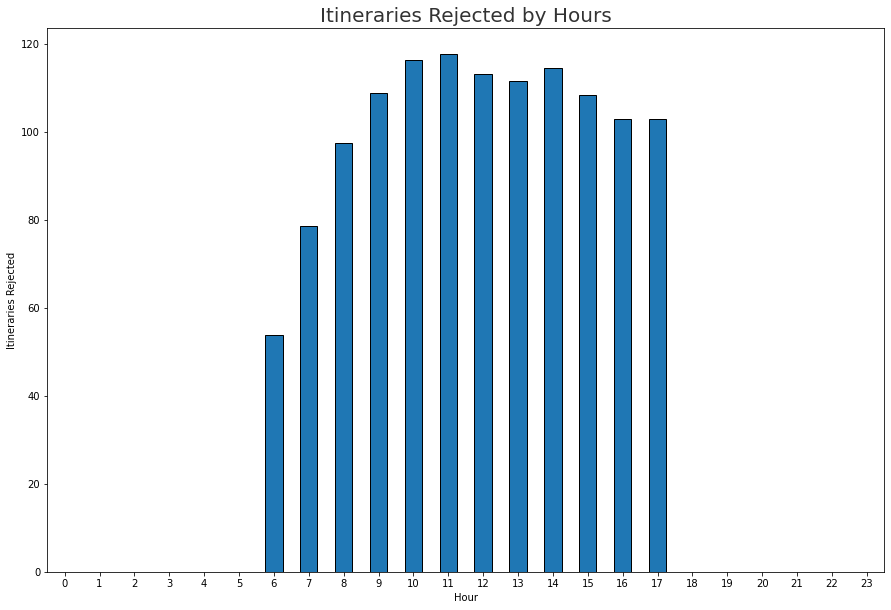

In [67]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Hora')['Reject'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Itineraries Rejected')
plt.xlabel('Hour')
plt.title('Itineraries Rejected by Hours', alpha=0.8, fontsize=20)

Text(0.5, 1.0, 'Itineraries Unmatched by Hours')

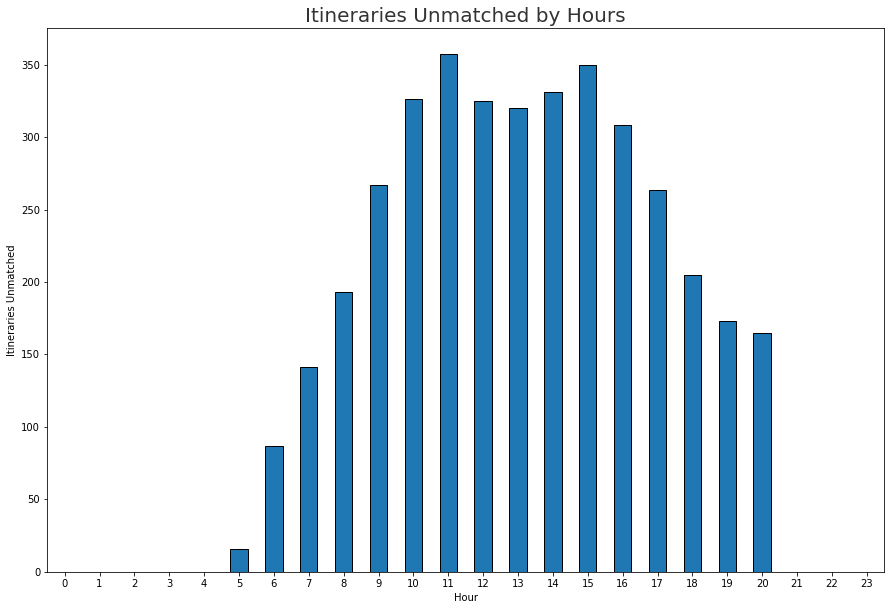

In [91]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Hora')['Unmatch'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Itineraries Unmatched')
plt.xlabel('Hour')
plt.title('Itineraries Unmatched by Hours', alpha=0.8, fontsize=20)

Text(0.5, 1.0, 'Real Drivers Availability by Hours')

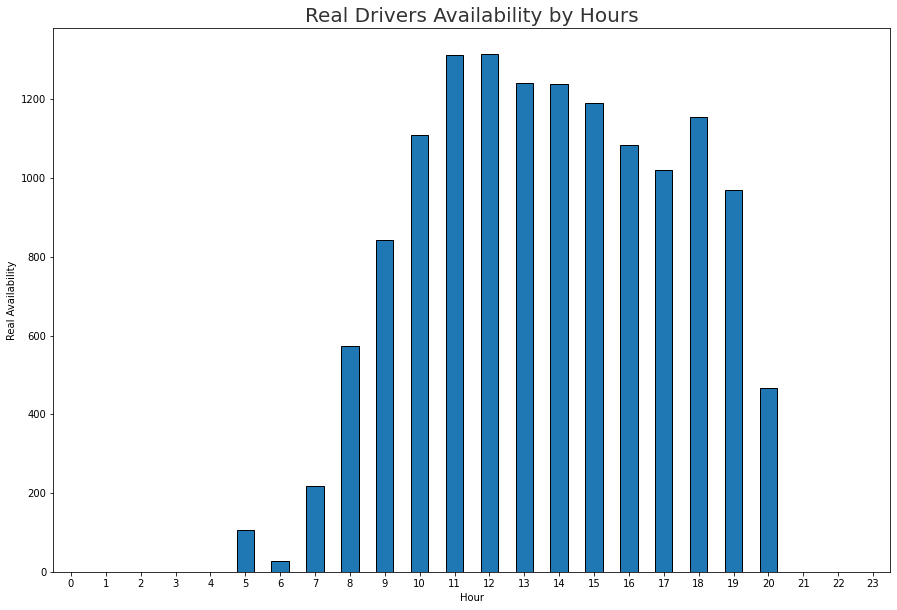

In [92]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Hora')['Offer'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Real Availability')
plt.xlabel('Hour')
plt.title('Real Drivers Availability by Hours', alpha=0.8, fontsize=20)

Text(0.5, 1.0, 'Availability by Day')

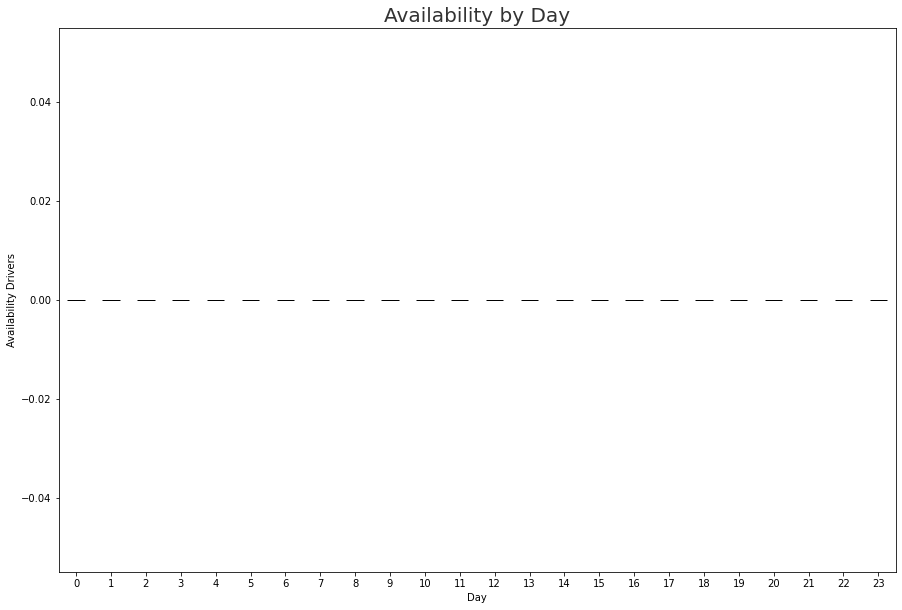

In [98]:
plt.figure(figsize=(15,10))

df_merged_w.groupby('Dia')['Avail'].mean().reindex(np.arange(0,24,1)).plot(kind='bar', rot=0, ec='k', legend=False)

plt.ylabel('Availability Drivers')
plt.xlabel('Day')
plt.title('Availability by Day', alpha=0.8, fontsize=20)

## Statistical Information about variables

Text(0.5, 1.0, 'Correlations between Some Variables')

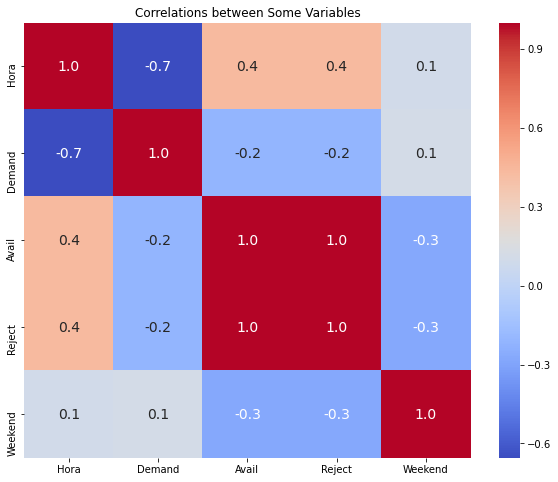

In [69]:
df_corr = df_merged_w[['Hora','Demand','Avail','Reject', 'Weekend']]

plt.figure(figsize=(10,8))

sns.heatmap(df_corr.corr(), cmap='coolwarm',fmt=".1f",annot_kws ={'size':14}, annot=True)

plt.title("Correlations between Some Variables")

In [94]:
df_merged_dummy.columns

Index(['Dia', 'Hora', 'Demand', 'Avail', 'Reject', 'Unmatch', 'Offer', 'Prec',
       'Weekend', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday'],
      dtype='object')

Text(0.5, 1.0, 'Correlations between Some Variables')

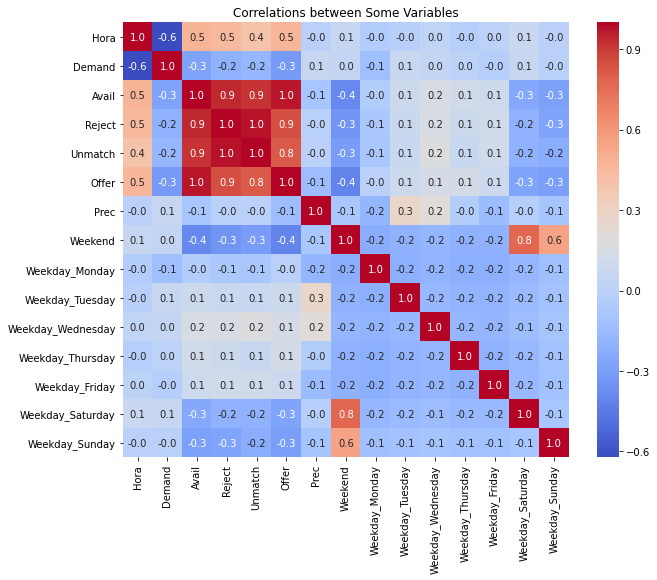

In [96]:
df_corr = df_merged_dummy[['Hora', 'Demand', 'Avail', 'Reject', 'Unmatch', 'Offer', 'Prec',
       'Weekend', 'Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday',
       'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday']]

plt.figure(figsize=(10,8))

sns.heatmap(df_corr.corr(), cmap='coolwarm',fmt=".1f",annot_kws ={'size':10}, annot=True)

plt.title("Correlations between Some Variables")

In [97]:
df_merged_w.describe()

,Hora,Demand,Avail,Reject,Unmatch,Offer,Prec,Weekend
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,11.586420,15.716049,1865.805556,689.620370,258.944444,917.240741,7.745062,0.175926
std,3.856794,16.980582,1071.616072,314.866694,143.355098,658.066003,18.612007,0.381346
min,5.000000,1.000000,126.000000,21.000000,3.000000,-71.000000,0.000000,0.000000
25%,8.000000,3.000000,934.000000,435.500000,140.750000,285.500000,0.000000,0.000000
50%,12.000000,9.000000,1841.000000,641.000000,229.000000,921.000000,0.000000,0.000000
75%,15.000000,22.000000,2933.750000,993.750000,396.000000,1493.000000,6.200000,0.000000
max,20.000000,93.000000,3700.000000,1171.000000,530.000000,2343.000000,101.600000,1.000000
